In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    #acc_numbers = df.iloc[:, 0]
    #bad_tags = df['bad_flag']
    #features = df.drop(columns=['bad_flag'])
    features = df
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    return scaled_features, scaler

file_path = '/content/drive/MyDrive/reduced_val_dataset.csv'  # Replace with your file path
X, scaler = load_and_preprocess_data(file_path)

Epoch 1/100
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.2095 - val_loss: 0.1490 - learning_rate: 0.0010
Epoch 2/100
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.1487 - val_loss: 0.1432 - learning_rate: 0.0010
Epoch 3/100
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.1437 - val_loss: 0.1403 - learning_rate: 0.0010
Epoch 4/100
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.1422 - val_loss: 0.1383 - learning_rate: 0.0010
Epoch 5/100
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.1396 - val_loss: 0.1372 - learning_rate: 0.0010
Epoch 6/100
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 0.1402 - val_loss: 0.1361 - learning_rate: 0.0010
Epoch 7/100
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - loss: 0.1375 - val_loss: 0.1359 - learning_rate: 0.0010
Epoch 8/100
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 0.1378 - val_loss: 0.1350 - learning_rate: 0.0010
Epoch 9/100
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.1370 - val_lo

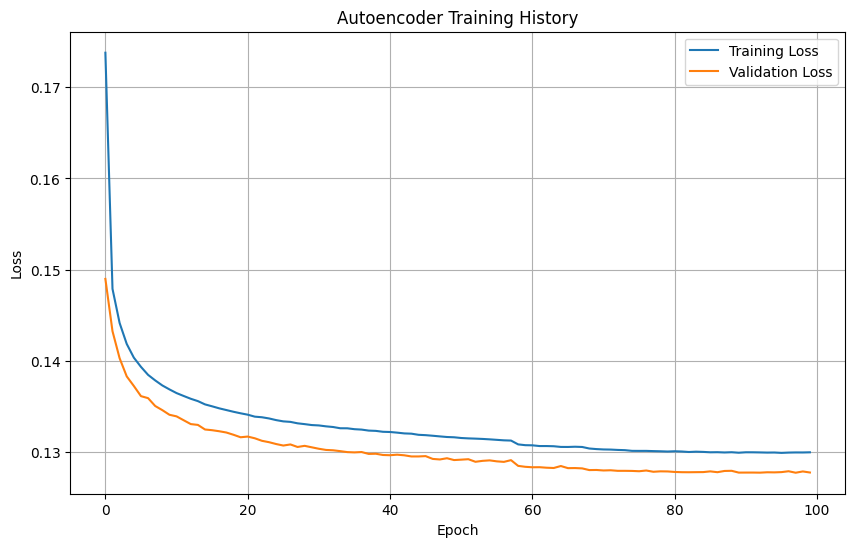

1306/1306 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


NameError: name 'y' is not defined

In [ ]:


def create_autoencoder(input_dim, encoding_dim=50):
    input_layer = layers.Input(shape=(input_dim,))

    # Encoder
    encoded = layers.Dense(256, activation='swish')(input_layer)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.Dropout(0.3)(encoded)
    encoded = layers.Dense(256, activation='swish')(encoded)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.Dense(encoding_dim, activation='swish')(encoded)

    # Decoder
    decoded = layers.Dense(256, activation='swish')(encoded)
    decoded = layers.BatchNormalization()(decoded)
    decoded = layers.Dropout(0.3)(decoded)
    decoded = layers.Dense(256, activation='swish')(decoded)
    decoded = layers.BatchNormalization()(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    return autoencoder, encoder

def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Autoencoder Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training autoencoder
def train_autoencoder(X, encoding_dim=80, epochs=100, batch_size=32):
    input_dim = X.shape[1]
    autoencoder, encoder = create_autoencoder(input_dim, encoding_dim)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=Huber())

    X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(X_val, X_val),
        callbacks=callbacks
    )

    reconstructed_train = autoencoder.predict(X_train)
    reconstructed_val = autoencoder.predict(X_val)

    train_mse = mean_squared_error(X_train, reconstructed_train)
    val_mse = mean_squared_error(X_val, reconstructed_val)

    print("\nReconstruction Error Analysis:")
    print(f"Training MSE: {train_mse:.6f}")
    print(f"Validation MSE: {val_mse:.6f}")

    plot_training_history(history)

    return autoencoder, encoder, history

# Testing different encoding dimensions
def plot_dimension_analysis(X, input_dim, dim_range=[10, 30, 50, 70, 100]):
    reconstruction_errors = []

    for dim in dim_range:
        print(f"Testing encoding dimension: {dim}")
        autoencoder, _ = create_autoencoder(input_dim, encoding_dim=dim)
        autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=Huber())

        X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
        autoencoder.fit(
            X_train, X_train,
            epochs=30,
            batch_size=32,
            validation_data=(X_val, X_val),
            verbose=0
        )

        reconstructed = autoencoder.predict(X_val)
        mse = mean_squared_error(X_val, reconstructed)
        reconstruction_errors.append(mse)

    plt.figure(figsize=(10, 6))
    plt.plot(dim_range, reconstruction_errors, 'bo-')
    plt.title('Reconstruction Error vs Encoding Dimension')
    plt.xlabel('Encoding Dimension')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.show()

    return dim_range, reconstruction_errors

# Main execution
autoencoder, encoder, history = train_autoencoder(X, encoding_dim=100)
encoded_features = encoder.predict(X)

encoded_df = pd.DataFrame(
    encoded_features,
    columns=[f'feature_{i}' for i in range(encoded_features.shape[1])]
)

final_df = pd.concat([
    #pd.Series(acc_numbers).reset_index(drop=True),
    pd.Series(y).reset_index(drop=True),
    encoded_df
], axis=1)

final_df.to_csv('reduced_credit_data.csv', index=False)
final_df.head()

In [ ]:
encoded_df.to_csv('reduced_data_autoenc_val.csv', index=False)

NN Normal

Epoch [5/5000], Train Loss: 0.2971, Validation Loss: 0.5427
Epoch [10/5000], Train Loss: 0.2836, Validation Loss: 0.5296
Epoch [15/5000], Train Loss: 0.2663, Validation Loss: 0.5120
Epoch [20/5000], Train Loss: 0.2420, Validation Loss: 0.4856
Epoch [25/5000], Train Loss: 0.2059, Validation Loss: 0.4427
Epoch [30/5000], Train Loss: 0.1516, Validation Loss: 0.3690
Epoch [35/5000], Train Loss: 0.0846, Validation Loss: 0.2562
Epoch [40/5000], Train Loss: 0.0338, Validation Loss: 0.1334
Epoch [45/5000], Train Loss: 0.0167, Validation Loss: 0.0583
Epoch [50/5000], Train Loss: 0.0142, Validation Loss: 0.0306
Epoch [55/5000], Train Loss: 0.0140, Validation Loss: 0.0216
Epoch [60/5000], Train Loss: 0.0140, Validation Loss: 0.0183
Epoch [65/5000], Train Loss: 0.0141, Validation Loss: 0.0170
Epoch [70/5000], Train Loss: 0.0141, Validation Loss: 0.0164
Epoch [75/5000], Train Loss: 0.0141, Validation Loss: 0.0162
Epoch [80/5000], Train Loss: 0.0141, Validation Loss: 0.0160
Epoch [85/5000], Train Lo

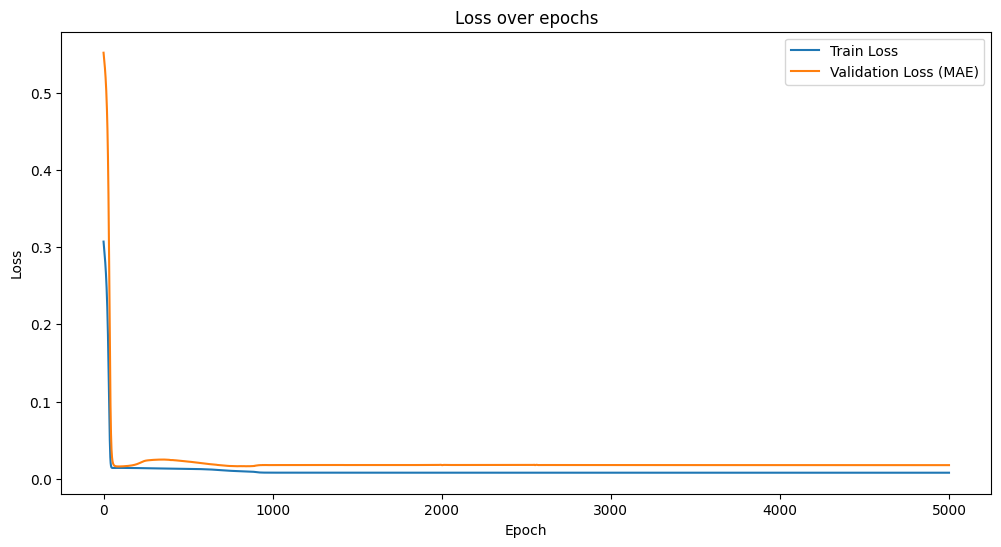

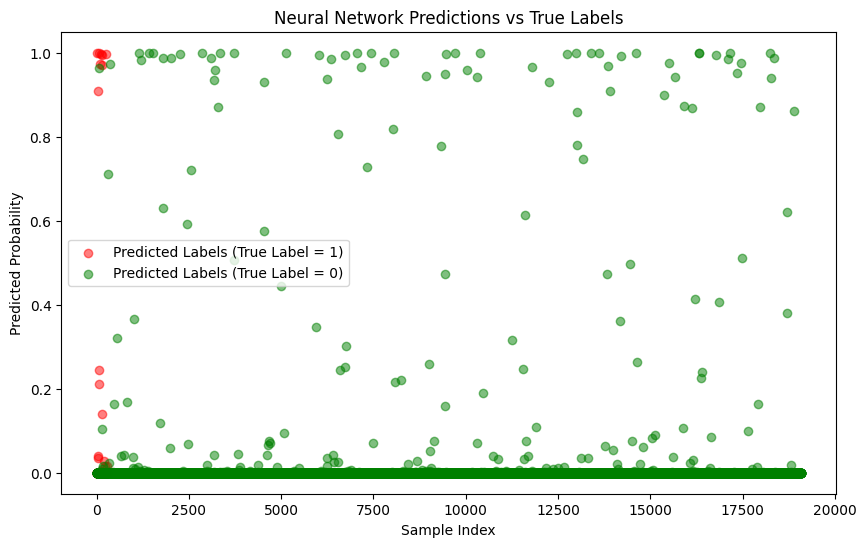

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


#data = final_df.drop(final_df.columns[0], axis=1)
data = pd.read_csv('/content/drive/MyDrive/reduced_data_autoencoder2.csv')

# Remove the last row with NaN values
data_cleaned = data.dropna()

# Split the data into features (X) and target labels (y)
X_cleaned = data_cleaned.iloc[:, 1:].values
y_cleaned = data_cleaned.iloc[:, 0].values

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_cleaned, y_cleaned, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Scale the data for Neural Network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the Neural Network model
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedforwardNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

# Initialize the model
input_dim = X_train_scaled.shape[1]
model = FeedforwardNN(input_dim)


criterion_mse = nn.MSELoss()  # Mean Squared Error loss for regression
criterion_mae = nn.L1Loss()   # Mean Absolute Error loss for validation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients
    y_train_pred = model(X_train_tensor)  # Forward pass
    loss = criterion_mse(y_train_pred, y_train_tensor)  # Compute MSE loss for training
    loss.backward()  # Backpropagate the gradients
    optimizer.step()  # Update the weights

    # Record training loss
    train_losses.append(loss.item())

    # Validation loss using MAE
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        y_val_pred = model(X_val_tensor)
        val_loss = criterion_mae(y_val_pred, y_val_tensor)  # Compute MAE for validation
        val_losses.append(val_loss.item())

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Make predictions on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_prob)
print(f'\nMean Squared Error (MSE): {mse:.4f}')

# Create a DataFrame with predicted probabilities and actual labels
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Prob': y_pred_prob.flatten()
})

print("\nFirst few rows of the DataFrame:")
print(results_df.head())

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss (MAE)')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))

# For true label 1, show predicted labels in red
plt.scatter(range(len(y_test[y_test == 1])), y_pred_prob.flatten()[y_test == 1], color='red', label='Predicted Labels (True Label = 1)', alpha=0.5)

# For true label 0, show predicted labels in green
plt.scatter(range(len(y_test[y_test == 0])), y_pred_prob.flatten()[y_test == 0], color='green', label='Predicted Labels (True Label = 0)', alpha=0.5)

plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Neural Network Predictions vs True Labels')
plt.legend()
plt.show()

NN Weighted MSE


Epoch [5/5000], Train Loss: 0.8747, Validation Loss: 0.0777
Epoch [10/5000], Train Loss: 0.7893, Validation Loss: 0.1200
Epoch [15/5000], Train Loss: 0.6956, Validation Loss: 0.1653
Epoch [20/5000], Train Loss: 0.5563, Validation Loss: 0.2304
Epoch [25/5000], Train Loss: 0.3838, Validation Loss: 0.3280
Epoch [30/5000], Train Loss: 0.2771, Validation Loss: 0.4591
Epoch [35/5000], Train Loss: 0.3017, Validation Loss: 0.5274
Epoch [40/5000], Train Loss: 0.2579, Validation Loss: 0.4902
Epoch [45/5000], Train Loss: 0.2513, Validation Loss: 0.4579
Epoch [50/5000], Train Loss: 0.2504, Validation Loss: 0.4665
Epoch [55/5000], Train Loss: 0.2404, Validation Loss: 0.4986
Epoch [60/5000], Train Loss: 0.2383, Validation Loss: 0.5193
Epoch [65/5000], Train Loss: 0.2350, Validation Loss: 0.5078
Epoch [70/5000], Train Loss: 0.2314, Validation Loss: 0.4878
Epoch [75/5000], Train Loss: 0.2288, Validation Loss: 0.4837
Epoch [80/5000], Train Loss: 0.2260, Validation Loss: 0.4859
Epoch [85/5000], Train Lo

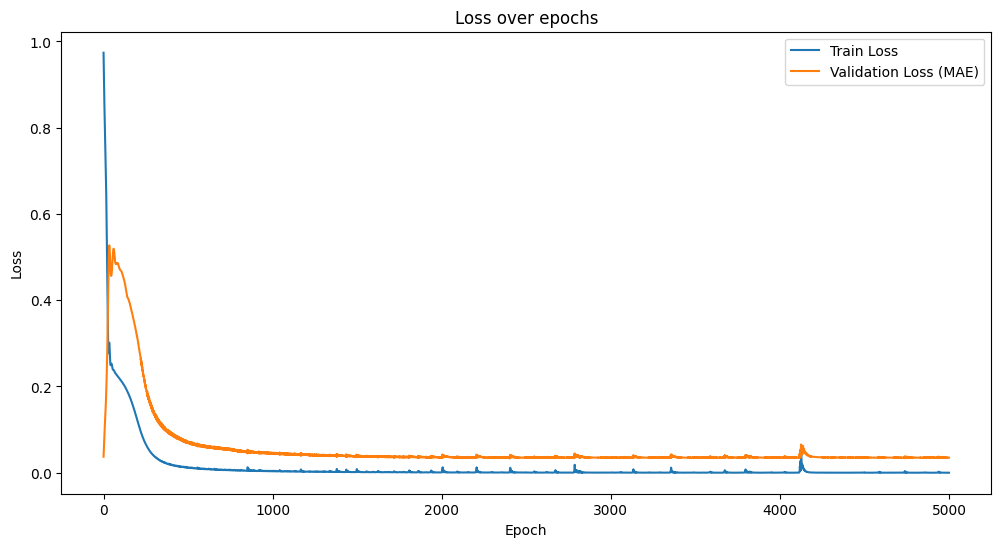

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from collections import Counter

# Load the data
data = pd.read_csv('/content/drive/MyDrive/reduced_data_autoencoder2.csv')

# Remove the last row with NaN values
data_cleaned = data.dropna()

# Split the data into features (X) and target labels (y)
X_cleaned = data_cleaned.iloc[:, 1:].values
y_cleaned = data_cleaned.iloc[:, 0].values

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_cleaned, y_cleaned, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Scale the data for Neural Network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Calculate class weights
class_counts = Counter(y_train)
total_samples = len(y_train)
scaling_factor = 2
class_weights = {
    label: (scaling_factor if count == min(class_counts.values()) else 1.0) * (total_samples / (len(class_counts) * count))
    for label, count in class_counts.items()
}

# Create a weight tensor for the training labels
weights_tensor = torch.tensor([class_weights[label] for label in y_train], dtype=torch.float32)

# Define the custom weighted MSE loss function
def weighted_mse_loss(predictions, targets, weights):
    mse = (predictions - targets) ** 2
    weighted_mse = mse * weights.view(-1, 1)  # Apply weights
    return torch.mean(weighted_mse)

# Define the Neural Network model
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedforwardNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.output_layer(x)
        return x

# Initialize the model
input_dim = X_train_scaled.shape[1]
model = FeedforwardNN(input_dim)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients
    y_train_pred = model(X_train_tensor)  # Forward pass
    loss = weighted_mse_loss(y_train_pred, y_train_tensor, weights_tensor)  # Custom weighted MSE loss
    loss.backward()  # Backpropagate the gradients
    optimizer.step()  # Update the weights

    # Record training loss
    train_losses.append(loss.item())

    # Validation loss using MAE
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        y_val_pred = model(X_val_tensor)
        val_loss = nn.L1Loss()(y_val_pred, y_val_tensor)  # Compute MAE for validation
        val_losses.append(val_loss.item())

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Make predictions on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_prob)
print(f'\nMean Squared Error (MSE): {mse:.4f}')

# Create a DataFrame with predicted probabilities and actual labels
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Prob': y_pred_prob.flatten()
})

# Show first few rows of the DataFrame
print("\nFirst few rows of the DataFrame:")
print(results_df.head())


# Plot the training and validation losses over epochs
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss (MAE)')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NN Weighted with BCE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/content/drive/MyDrive/reduced_data_autoencoder2.csv')

# Remove the last row with NaN values
data_cleaned = data.dropna()

# Split the data into features (X) and target labels (y)
X_cleaned = data_cleaned.iloc[:, 1:].values
y_cleaned = data_cleaned.iloc[:, 0].values

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_cleaned, y_cleaned, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Scale the data for Neural Network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Calculate class weights
class_counts = {0: (y_train == 0).sum().item(), 1: (y_train == 1).sum().item()}
total_samples = len(y_train)
class_weights = {
    0: (2 * (total_samples / (2 * class_counts[0]))),  # Give twice the weight to the minority class (class 1)
    1: (2 * (total_samples / (2 * class_counts[1]))),  # Keep original weight for majority class
}

# Create a weight tensor for the training labels
weights_tensor = torch.tensor([class_weights[label] for label in y_train], dtype=torch.float32)

# Define the Neural Network model
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedforwardNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.output_layer(x)
        return x  # No sigmoid, as BCEWithLogitsLoss applies it internally

# Initialize the model
input_dim = X_train_scaled.shape[1]
model = FeedforwardNN(input_dim)

# Define the BCEWithLogits loss function with weights for each class
criterion_bce_logits = nn.BCEWithLogitsLoss(weight=weights_tensor)  # Weighted BCEWithLogits Loss

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients
    y_train_pred = model(X_train_tensor)  # Forward pass
    loss = criterion_bce_logits(y_train_pred, y_train_tensor)  # Compute BCE loss
    loss.backward()  # Backpropagate the gradients
    optimizer.step()  # Update the weights

    # Record training loss
    train_losses.append(loss.item())

    # Validation loss using BCEWithLogitsLoss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        y_val_pred = model(X_val_tensor)
        val_loss = criterion_bce_logits(y_val_pred, y_val_tensor)  # Compute BCE for validation
        val_losses.append(val_loss.item())

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Make predictions on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred_prob = torch.sigmoid(model(X_test_tensor)).numpy()  # Apply sigmoid to logits for probabilities

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_prob)
print(f'\nMean Squared Error (MSE): {mse:.4f}')

# Create a DataFrame with predicted probabilities and actual labels
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Prob': y_pred_prob.flatten()
})

# Show first few rows of the DataFrame
print("\nFirst few rows of the DataFrame:")
print(results_df.head())

# Plot the training and validation losses over epochs
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss (BCE)')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Scatter plot of predictions vs true labels
plt.figure(figsize=(10, 6))

# For true label 1, show predicted labels in red
plt.scatter(range(len(y_test[y_test == 1])), y_pred_prob.flatten()[y_test == 1], color='red', label='Predicted Labels (True Label = 1)', alpha=0.5)

# For true label 0, show predicted labels in green
plt.scatter(range(len(y_test[y_test == 0])), y_pred_prob.flatten()[y_test == 0], color='green', label='Predicted Labels (True Label = 0)', alpha=0.5)

plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Neural Network Predictions vs True Labels')
plt.legend()
plt.show()

RuntimeError: output with shape [58083, 1] doesn't match the broadcast shape [58083, 58083]

Confusion Plots

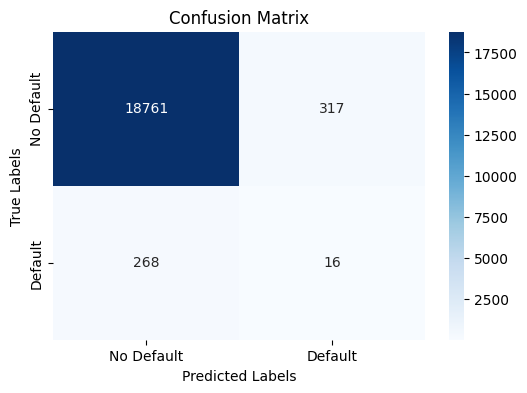

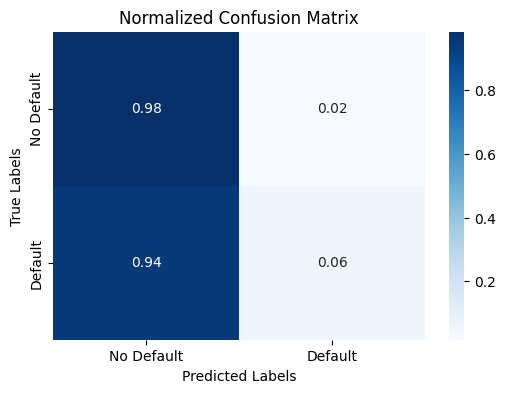

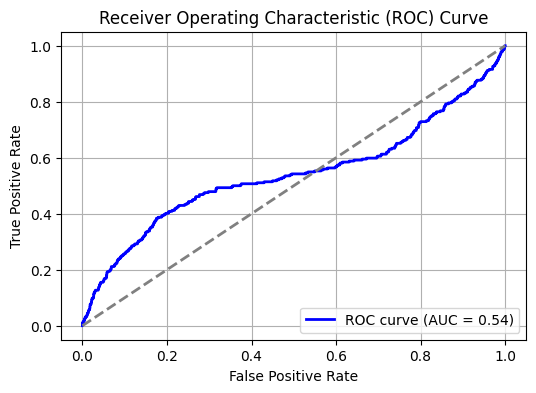

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# Create a DataFrame with predicted probabilities and actual labels
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Prob': y_pred_prob.flatten()
})

# Calculate confusion matrix
threshold = 0.5
y_pred = (results_df['Predicted_Prob'] >= threshold).astype(int)
conf_matrix = confusion_matrix(results_df['True_Label'], y_pred)

# Plot raw confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Normalize confusion matrix by rows (true labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(results_df['True_Label'], results_df['Predicted_Prob'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()
